# Pattern Matrix Replacement

This this notebook we explore strategies to replace the ***Hit Correlation*** step of Konrad's pipeline, specifically the *patten matrix* algorithm previously used.

## Approach
I am thinking of two approaches. First, use a simple MLP to determine if two given points are *causally related* or not. To do this, the following tasks are required:
- [x] prepare the data such that each row contains the features (x,y,z,time/timeslice) of each pair of points (exluding self)
    - [ ] subtask here is to use PCA to reduce the dimensions and see if the network performs same/worse
- [X] create labels for training set ie. *1* of related and *0* otherwise (this hinges upon the fact that we can extract labels from *mc_info* table)
- [ ] visualize the results

The other approach is to treat this as an unsupervised learning task and use clustering to determine *related* points.

# Creating the "Pattern Matrix" Dataset

Since this step will essentially double the width of the dataset and square it's height, we will only use timeslice 665 (timeslice with the largest hits, as per the [exploration](notebooks/exploration.ipynb) conducted previously). The algorithm to generate the dataset is as follows:
1. create an empty dataframe to hold the `result`
2.iterate over original df with the row and index
    1. duplicate original df
    2. set value of `dup` columns to that of the row
    3. concat dup and original dfs (sideways) to create pairs
    4. drop the rows where `id1` is less than `id2` to avoid repeat pairs
    5. append dup to result
    
The algorithm was tested with a small sample of 10 rows before the dataset below was created.

## Generate labels

Once we "explode" the dataset, we need to generate labels. The logic is simple, if `eid1` and `eid2` are same then give it a label of 1, else a label of 0. There are 3 possible combinations that can occur: 1. hit-hit 2. hit-noise and 3. noise-noise. Since noise has `nan` for the event ids and since in Python `nan != nan` all 3 cases can be correctly handled by a simple comparison of the two column values.

Drop the columns that are not required for training, and write to csv.

# Alternative datasets

- [x] train using the difference between x,y,z,t ***This produced better results***
- [x] train using a larger sample (50%, 75%, 100% of slice-615) ***50% produced the best results***
- [ ] train using sample from entire dataset, across timeslices

# MLP for "Pattern Matrix" Replacement

I followed this [tutorial](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/) to implement the first iteration of the network.

## Summary of experiments
The following parameters were constant across all experiments:

|param|value|
|:-:|:-:|
|loss|BCELoss|
|optimizer|SGD with lr=0.001, momentum=0.9|
|model architecture| (inputs, 10), (10, 8)|
|activation (hidden)|ReLu|
|activation (output)|Sigmoid|

Two parameters namely, the size of the training set and the number of epochs were varied in a grid search and the optimal values were identified (ie. the point where validation and training losses converge). The results are summarised below.

|dataset|epochs|size (training)|accuracy|recall (related)|recall (unrelated)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|train-slice-615-10-equal|10|9253|0.88|0.11|0.90|
|train-slice-615-25-equal|10|42407|0.94|0.44|0.96|
|train-slice-615-25-equal|25|42407|0.96|0.19|0.98|
|train-slice-615-50-equal|10|193898|0.95|0.42|0.96|
|train-slice-615-50-equal|5|193898|--|0.43|0.97|
|train-slice-615-50-equal-diff|5|193898|0.93|0.76|0.93|
|train-slice-615-50-equal-diff|2|193898|0.93|0.84|0.91|

The best model is obtained by using dataset train-slice-615-50-equal-diff which contains equal number of examples for each target and uses the difference between the points as the feature columns.

***NOTE the recall varies for each experiment due to random initialization of weights but in general it follows an error of +-5%.***

## Experiment 1
Use **scripts/train-slice-615-10-equal.csv** to generate the dataset.

### Parameters
- Data: 10% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
The model is not able to classify the minority class well.

In [1]:
from context import km3net
from km3net.utils import DATADIR
import km3net.model.utils as model_utils
import km3net.model.eval as model_eval
import km3net.data.utils as data_utils
import km3net.data.pattern_matrix as pm
from km3net.model.mlp import MLP
from torch.nn import BCELoss
from torch.optim import SGD
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_path = DATADIR+'/train/slice-615-10-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 9253, valid size: 4557, test size: 364231
---
epochs: 0, train loss: 0.040, valid loss: 0.037
epochs: 5, train loss: 0.028, valid loss: 0.027
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

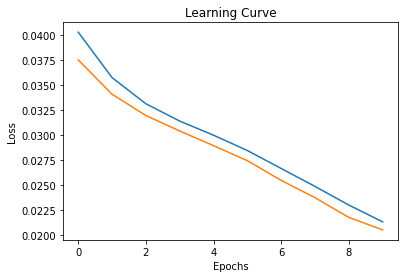

<Figure size 576x576 with 0 Axes>

In [3]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

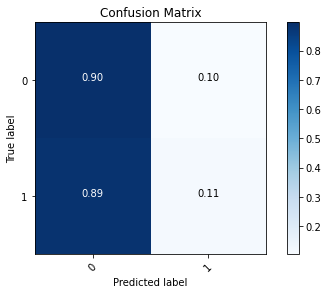

<Figure size 576x576 with 0 Axes>

In [4]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [5]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94    355859
         1.0       0.03      0.11      0.04      8372

    accuracy                           0.88    364231
   macro avg       0.50      0.51      0.49    364231
weighted avg       0.96      0.88      0.91    364231



## Experiment 1.a
Next, we increase the size of training set whilst keeping the parameters the same.

### Parameters
- Data: 25% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
The loss functions are now stable and seem to converge, the recall for related hits also improves.

In [6]:
train_path = DATADIR+'/train/slice-615-25-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 42407, valid size: 20887, test size: 364231
---
epochs: 0, train loss: 0.039, valid loss: 0.033
epochs: 5, train loss: 0.012, valid loss: 0.011
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

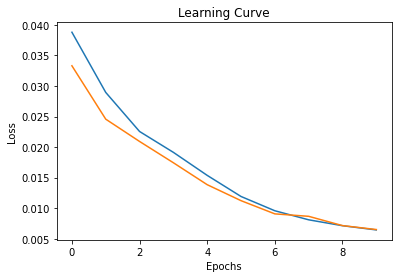

<Figure size 576x576 with 0 Axes>

In [7]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

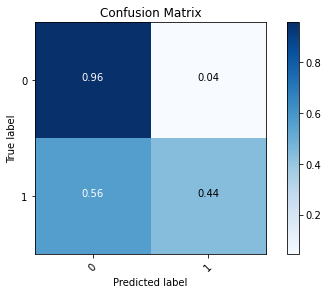

<Figure size 576x576 with 0 Axes>

In [8]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [9]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97    355859
         1.0       0.19      0.44      0.26      8372

    accuracy                           0.94    364231
   macro avg       0.59      0.70      0.62    364231
weighted avg       0.97      0.94      0.95    364231



## Experiment 1.a.1
As an alternate path, we try increasing the training epochs to see if it helps the model.

### Remarks
Recall for related hits **decreases**, we can try with 12 epochs, but 10 seems to be a good number for this dataset. Also note that increasing the training size might require reducing the epochs for better results.

In [ ]:
train_path = DATADIR+'/train/slice-615-25-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 25,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

In [ ]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

In [ ]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [5]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    355859
         1.0       0.21      0.19      0.20      8372

    accuracy                           0.96    364231
   macro avg       0.59      0.59      0.59    364231
weighted avg       0.96      0.96      0.96    364231



## Experiment 1.b
Increase the size of training set to 50% of slice-615 whilst keeping the parameters the same.

### Parameters
- Data: 50% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
The loss functions converge way before 10 epochs, and the recall for related hits is similar to exp.2, we can try early stopping.

In [2]:
train_path = DATADIR+'/train/slice-615-50-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 193898, valid size: 95502, test size: 364231
---
epochs: 0, train loss: 0.023, valid loss: 0.012
epochs: 5, train loss: 0.007, valid loss: 0.007
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

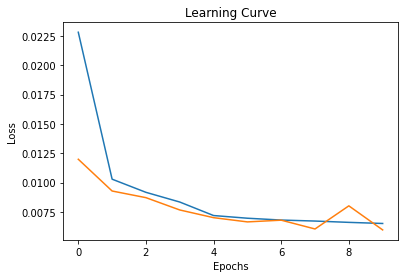

<Figure size 576x576 with 0 Axes>

In [3]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

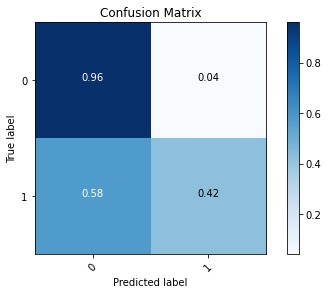

<Figure size 576x576 with 0 Axes>

In [4]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [5]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97    355859
         1.0       0.20      0.42      0.27      8372

    accuracy                           0.95    364231
   macro avg       0.59      0.69      0.62    364231
weighted avg       0.97      0.95      0.96    364231



## Experiment 1.b.1
With the increased training data, we do not need 10 epochs, from the learning curve of exp.3 we see that 5 seems to be a good place to stop.

### Parameters
- Data: 50% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 5

### Remarks
From the learning curve it seems we can stop 1-2 epochs earlier but that may/may not result in any significant performance gain. It seems for the given parameters and model architecture we have acheived the best we can. Next, we try feature engineering.

In [6]:
train_path = DATADIR+'/train/slice-615-50-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 5,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 193898, valid size: 95502, test size: 364231
---
epochs: 0, train loss: 0.027, valid loss: 0.020
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

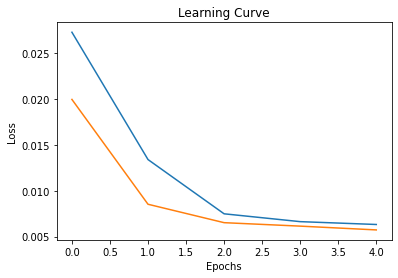

<Figure size 576x576 with 0 Axes>

In [7]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

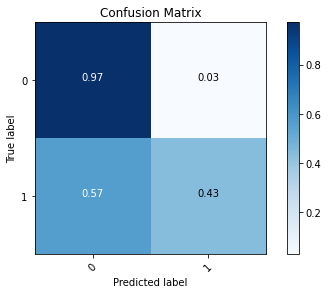

<Figure size 576x576 with 0 Axes>

In [8]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [5]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97    355859
         1.0       0.20      0.42      0.27      8372

    accuracy                           0.95    364231
   macro avg       0.59      0.69      0.62    364231
weighted avg       0.97      0.95      0.96    364231



## Experiment 2
We train the existing model with slice-615-50-equal-diff.csv which contains the difference of the points.

### Parameters
- Data: 50% of slice 615 (equalized classes, diff)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (4, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 5

### Remarks
The recall for related hits increases! From the learning curve it seems we can stop training even early.

In [29]:
train_path = DATADIR+'/train/slice-615-50-equal-diff.csv'
test_path = DATADIR+'/test/slice-1637-10-diff.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(4).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 5,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 193898, valid size: 95502, test size: 364231
---
epochs: 0, train loss: 0.026, valid loss: 0.013
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

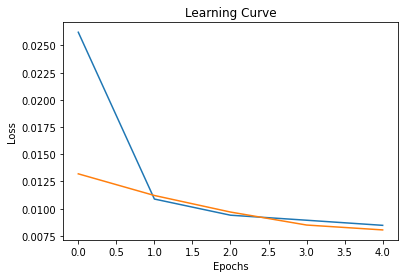

<Figure size 576x576 with 0 Axes>

In [30]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

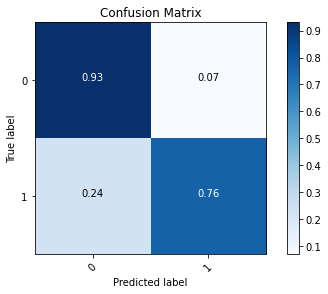

<Figure size 576x576 with 0 Axes>

In [31]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [32]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    355859
         1.0       0.21      0.76      0.32      8372

    accuracy                           0.93    364231
   macro avg       0.60      0.85      0.64    364231
weighted avg       0.98      0.93      0.95    364231



## Experiment 2.a
Stop training at 2 epochs

### Parameters
- Data: 50% of slice 615 (equalized classes, diff)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (4, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 2

### Remarks
Recall for related hits increases! We can try to reduce the data first and see if we can still acheive the same results.

In [67]:
train_path = DATADIR+'/train/slice-615-50-equal-diff.csv'
test_path = DATADIR+'/test/slice-1637-10-diff.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(4).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 3,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 193898, valid size: 95502, test size: 364231
---
epochs: 0, train loss: 0.033, valid loss: 0.017
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

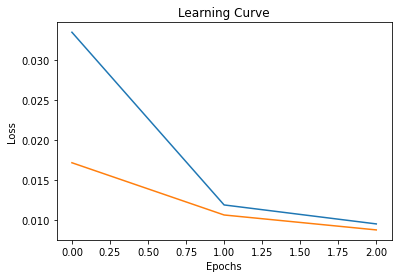

<Figure size 576x576 with 0 Axes>

In [68]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

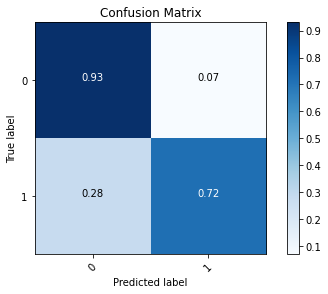

<Figure size 576x576 with 0 Axes>

In [69]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [70]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    355859
         1.0       0.20      0.72      0.31      8372

    accuracy                           0.93    364231
   macro avg       0.59      0.82      0.63    364231
weighted avg       0.97      0.93      0.95    364231



## Experiment 2.a.1
Reduce training data to 25% of slice 615, epochs varied to find best model.

### Parameters
- Data: 25% of slice 615 (equalized classes, diff)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (4, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 2, 5, 6, 10

### Remarks
|epochs|recall related(1)| recall unrelated(0)|
|:-:|:-:|:-:|
|2|higher|lower|
|3|higher|lower|
|5|lower|higher|

The model is a bit unreliable and does not acheive consistent accuracies, it does not beat the performance of the model from exp.2.a.

In [58]:
train_path = DATADIR+'/train/slice-615-25-equal-diff.csv'
test_path = DATADIR+'/test/slice-1637-10-diff.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(4).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 3,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 42407, valid size: 20887, test size: 364231
---
epochs: 0, train loss: 0.043, valid loss: 0.042
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

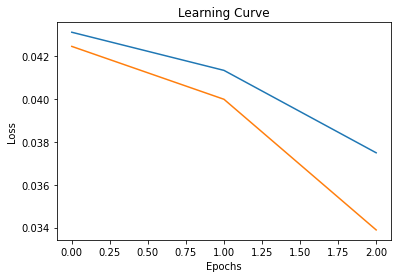

<Figure size 576x576 with 0 Axes>

In [59]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

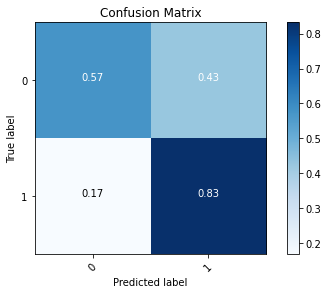

<Figure size 576x576 with 0 Axes>

In [60]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [42]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82    355859
         1.0       0.06      0.80      0.11      8372

    accuracy                           0.70    364231
   macro avg       0.53      0.75      0.47    364231
weighted avg       0.97      0.70      0.81    364231



## Experiment 2.a.2
Increase training data to 75% of slice 615, epochs varied to find best model.

### Parameters
- Data: 75% of slice 615 (equalized classes, diff)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (4, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 2

### Remarks
TODO

In [64]:
train_path = DATADIR+'/train/slice-615-75-equal-diff.csv'
test_path = DATADIR+'/test/slice-1637-10-diff.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(4).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 1,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 407162, valid size: 200542, test size: 364231
---
epochs: 0, train loss: 0.019, valid loss: 0.010
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

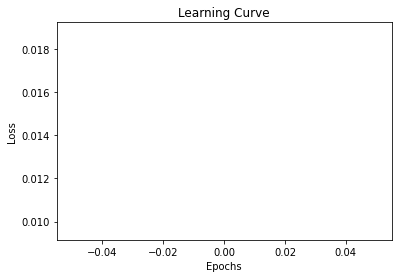

<Figure size 576x576 with 0 Axes>

In [65]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

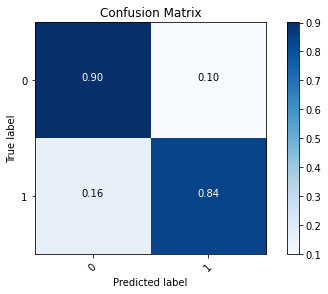

<Figure size 576x576 with 0 Axes>

In [66]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [42]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82    355859
         1.0       0.06      0.80      0.11      8372

    accuracy                           0.70    364231
   macro avg       0.53      0.75      0.47    364231
weighted avg       0.97      0.70      0.81    364231

